In [164]:
import os
import sys; sys.path.append("..")
import numpy as np
import torch
import random
import pandas as pd 
import matplotlib.pyplot as plt 

from collections import namedtuple
from pathlib import Path
from torch.utils.data import DataLoader
from src.datasets.fcgr import FCGRDataset


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [165]:
KMER = 8
EPOCHS = 50
outdir = Path(f"../experiments/fcgr/{KMER}mer")
outdir.mkdir(exist_ok=True, parents=True)

### Load data

In [166]:
list_fcgr = list(Path(f"../data/fcgr/{KMER}mer").rglob("*npy"))
label2int = {"clade_G": 0, "clade_O": 1, "clade_S": 2, "random": 3, }
random.shuffle(list_fcgr)
nsplit = int(0.8*len(list_fcgr))
train_dataset = FCGRDataset(list_fcgr=list_fcgr[:nsplit] , label2int=label2int)
test_dataset = FCGRDataset(list_fcgr=list_fcgr[nsplit:], label2int=label2int)

In [167]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Convolutional Neural network 


In [168]:
from src.models.cnn import CNNFCGR

model = CNNFCGR(num_classes=4, kmer=KMER).to(torch.float32)
model.to(device)
print(model)

CNNFCGR(
  (cnn1): Conv2d(1, 24, kernel_size=(2, 2), stride=(2, 2), bias=False)
  (cnn2): Conv2d(24, 20, kernel_size=(2, 2), stride=(2, 2), bias=False)
  (cnn3): Conv2d(20, 16, kernel_size=(2, 2), stride=(2, 2), bias=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense): Linear(in_features=16384, out_features=4, bias=True)
)


In [169]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [170]:
Epoch = namedtuple("Epoch",["train_loss","val_loss","train_acc", "val_acc", "saved_model"])
info_epochs = []
best_loss = 1_000_000

for epoch in range(EPOCHS):
    model.train()
    train_loss = []
    train_preds = []
    train_labels = []

    for data in train_loader:
        X, y = data
        X, y = X.to(device), y.to(device)
        out = model(X)  # Perform a single forward pass.
        loss = criterion(out, y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        train_loss.append(loss.cpu().detach().numpy())

        preds = out.argmax(axis=-1).cpu().detach().numpy()
        train_preds.extend(preds)
        train_labels.extend(y.cpu().detach().numpy())
        train_loss.append(loss.cpu().detach().numpy())

    # validation 
    model.eval()
    val_loss = []
    val_preds = []
    val_labels = []
    
    with torch.no_grad():
        for data in val_loader:
            X, y = data
            X, y = X.to(device), y.to(device)
            out = model(X)  # Perform a single forward pass.
            loss = criterion(out, y)  # Compute the loss.
            preds = out.argmax(axis=-1).cpu().detach().numpy()
            val_preds.extend(preds)
            val_labels.extend(y.cpu().detach().numpy())
            val_loss.append(loss.cpu().detach().numpy())

    # epoch metrics
    m_train_loss = np.array(train_loss).mean()
    m_val_loss = np.array(val_loss).mean()
    acc_train = (np.array(train_preds) == np.array(train_labels)).sum() / len(train_labels)
    acc_val = (np.array(val_preds) == np.array(val_labels)).sum() / len(val_labels)

    # save best model
    saved_model = False
    if m_val_loss < best_loss:
        print(m_val_loss, best_loss)
        torch.save(model.state_dict(), outdir.joinpath("best_model.pt"))
        best_loss = m_val_loss
        saved_model = True
    info_epochs.append( Epoch(m_train_loss, m_val_loss, acc_train, acc_val, saved_model) )
    print(f'Epoch: {epoch:03d}, Train-Loss: {m_train_loss:.4f}  | Val-Loss: {m_val_loss:.4f} | Best-Loss: {best_loss} | Trai-Acc: {acc_train} | Val-Acc: {acc_val}') 


0.058755383 1000000
Epoch: 000, Train-Loss: 0.3794  | Val-Loss: 0.0588 | Best-Loss: 0.058755382895469666 | Trai-Acc: 0.9158125 | Val-Acc: 0.98425
Epoch: 001, Train-Loss: 0.0686  | Val-Loss: 0.1606 | Best-Loss: 0.058755382895469666 | Trai-Acc: 0.9806875 | Val-Acc: 0.94075
0.044730384 0.058755383
Epoch: 002, Train-Loss: 0.0532  | Val-Loss: 0.0447 | Best-Loss: 0.04473038390278816 | Trai-Acc: 0.987125 | Val-Acc: 0.98725
Epoch: 003, Train-Loss: 0.0433  | Val-Loss: 0.0651 | Best-Loss: 0.04473038390278816 | Trai-Acc: 0.9889375 | Val-Acc: 0.98325
Epoch: 004, Train-Loss: 6.5165  | Val-Loss: 52.5063 | Best-Loss: 0.04473038390278816 | Trai-Acc: 0.959875 | Val-Acc: 0.70925
Epoch: 005, Train-Loss: 8.5430  | Val-Loss: 0.3978 | Best-Loss: 0.04473038390278816 | Trai-Acc: 0.951 | Val-Acc: 0.9825
Epoch: 006, Train-Loss: 0.2016  | Val-Loss: 0.3779 | Best-Loss: 0.04473038390278816 | Trai-Acc: 0.987125 | Val-Acc: 0.98025
Epoch: 007, Train-Loss: 0.0953  | Val-Loss: 0.1445 | Best-Loss: 0.04473038390278816 | 

In [171]:
train_metrics = pd.DataFrame(info_epochs)
train_metrics.to_csv(outdir.joinpath(f"train_metrics-{KMER}mer.csv"))

## Plots

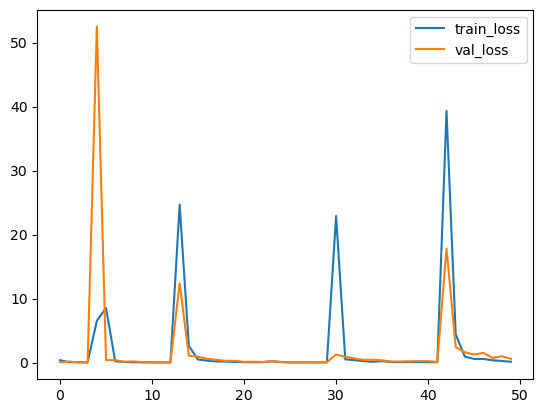

In [172]:
train_metrics[["train_loss","val_loss"]].plot()
plt.savefig(outdir.joinpath("training-loss.jpg"))

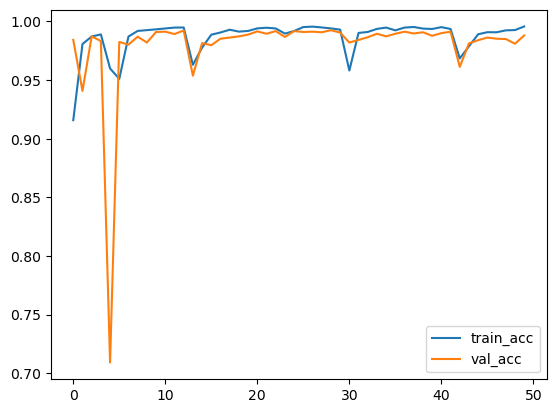

In [173]:
train_metrics[["train_acc","val_acc"]].plot()
plt.savefig(outdir.joinpath("training-acc.jpg"))

___

### Test

In [174]:
list_fcgr = list(Path(f"../data/fcgr-test/{KMER}mer").rglob("*npy"))
test_dataset = FCGRDataset(list_fcgr=list_fcgr, label2int=label2int)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [175]:
model = CNNFCGR(num_classes=4, kmer=KMER)
model.load_state_dict(torch.load( outdir.joinpath("best_model.pt")))
model.to(device)

CNNFCGR(
  (cnn1): Conv2d(1, 24, kernel_size=(2, 2), stride=(2, 2), bias=False)
  (cnn2): Conv2d(24, 20, kernel_size=(2, 2), stride=(2, 2), bias=False)
  (cnn3): Conv2d(20, 16, kernel_size=(2, 2), stride=(2, 2), bias=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense): Linear(in_features=16384, out_features=4, bias=True)
)

In [176]:
model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for data in test_loader:
        X, y = data
        X, y = X.to(device), y.to(device)
        out = model(X)  # Perform a single forward pass.
        preds = out.argmax(axis=-1).cpu().detach().numpy()
        test_preds.extend(preds)
        test_labels.extend(y.cpu().detach().numpy())
        

acc_test = (np.array(train_preds) == np.array(train_labels)).sum() / len(train_labels)

In [177]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(test_labels, test_preds,)
disp = ConfusionMatrixDisplay(cm, display_labels=label2int.keys())

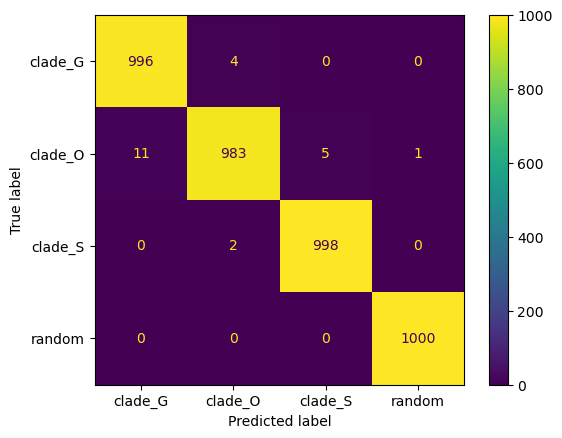

In [178]:
disp.plot()
plt.savefig(outdir.joinpath("confusion-matrix.jpg"))